# **Project_08_Building Face Detection & Recognition model with OpenCV: Camera Sticker**

## **1. 데이터 불러오기 및 확인**
---

### **1-1. 라이브러리 불러오기**

In [102]:
############################################## 라이브러리 불러오기 #####################################################
!pip install Cmake
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import urllib.request

### **1-2. 데이터 불러오기**

In [210]:
############################## 데이터 경로지정  ##############################

src_path =  os.getenv('HOME')+"/aiffel/camera_sticker"

face_img_name = "face.jpeg"
sticker_img_name = "cat-whiskers.png"
model_img_name = "shape_predictor_68_face_landmarks.dat"


face_img_path = os.path.join(src_path,"images",face_img_name)
sticker_img_path = os.path.join(src_path,"images",sticker_img_name)
model_path = os.path.join(src_path,"models",model_img_name)


In [211]:

############################## 데이터 불러오기  ##############################
face_img = cv2.imread(face_img_path)    #- OpenCV로 이미지를 읽어서
face_img_show = face_img.copy()      # 출력용 이미지를 따로 보관합니다

sticker_img = cv2.imread(sticker_img_path) 
sticker_img_show = sticker_img.copy()   

landmark_predictor = dlib.shape_predictor(model_path)


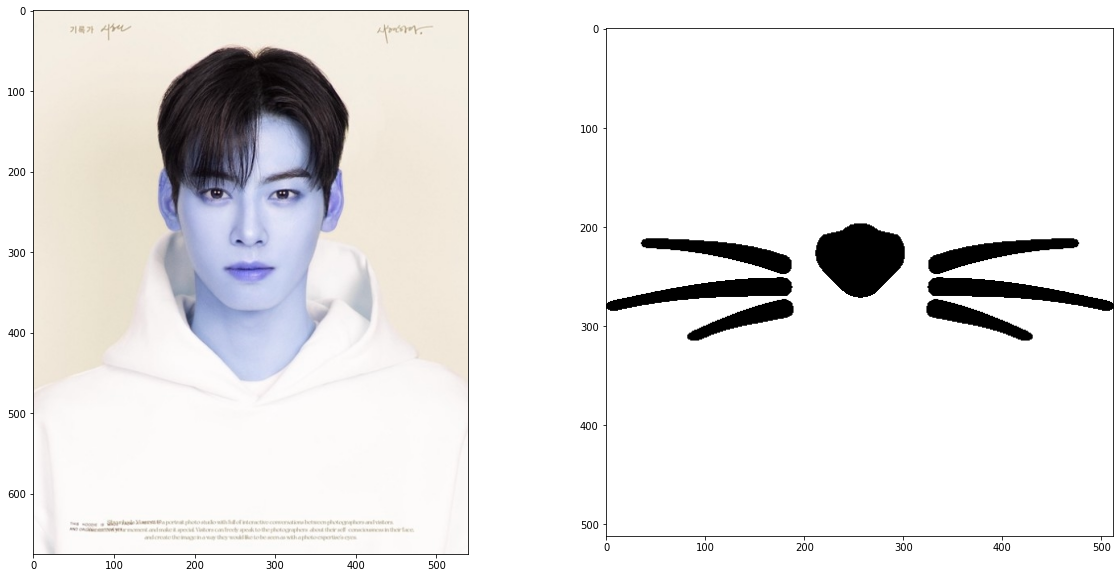

In [212]:

############################## 이미지 시각화  ##############################
figure, (ax1,ax2) =plt.subplots(nrows=1,ncols=2, figsize=(20,10))
ax1.imshow(face_img_show)
ax2.imshow(sticker_img_show)
plt.show()

> 왼쪽 이미지가 전반적으로 푸른빛이 도는데, 이는 opencv 가 BGR채널을 사용하기 때문이다. 이를 RGB로 바꿔주겠다.

### **1-3. 데이터 탐색 및 전처리**

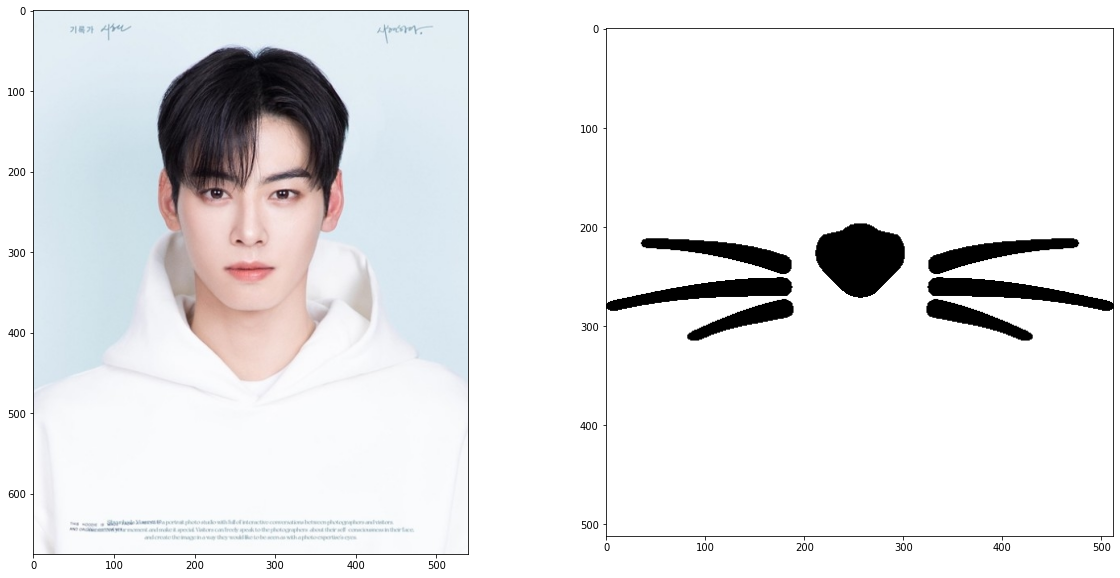

In [213]:
############################## 이미지채널 BGR-> RGB 로 변환하기##############################

face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
sticker_img_rgb = cv2.cvtColor(sticker_img, cv2.COLOR_BGR2RGB)

############################## 이미지 시각화  ##############################
figure, (ax1,ax2) =plt.subplots(nrows=1,ncols=2, figsize=(20,10))
ax1.imshow(face_img_rgb)
ax2.imshow(sticker_img_rgb)
plt.show()


> rgb로 변환이 잘된것을 볼 수 있다.

## **2. face detection**

In [214]:

##############################  hog detector를 선언  ##############################

detector_hog = dlib.get_frontal_face_detector()


##############################  얼굴의 bounding box 추출  ##############################


dlib_rects = detector_hog(face_img_rgb, 1)   # (image, num of image pyramid)



rectangles[[(180, 180) (366, 366)]]


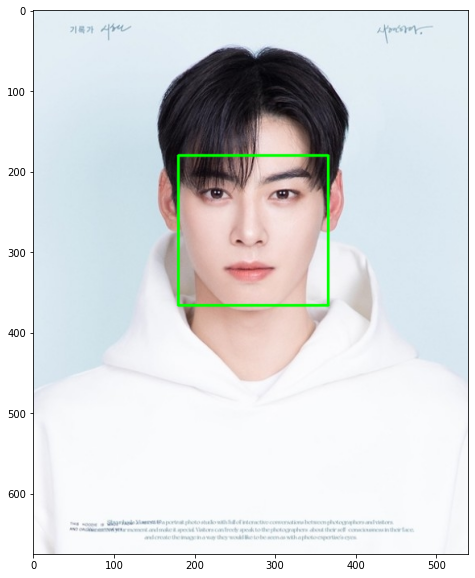

In [215]:
##############################  찾은 얼굴 영역 박스 리스트 시각화  ##############################
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(face_img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

face_img_show_rgb =  cv2.cvtColor(face_img_show, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(face_img_show_rgb)
plt.show()

## **3. face landmark localization**
---

In [216]:
##############################  얼굴영역박스마다 face landmark 찾기  ############################## 
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(face_img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


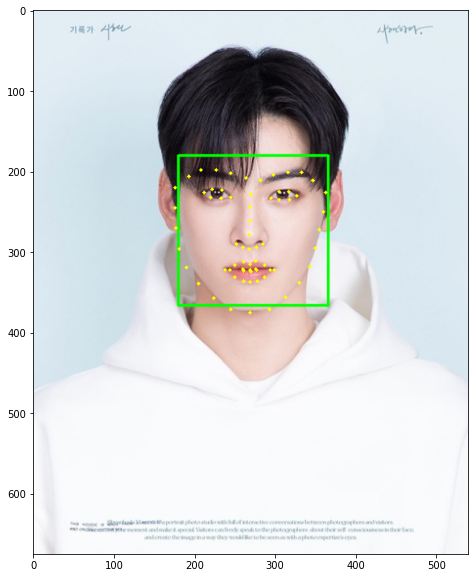

In [217]:
##############################  face landmark 영상에 출력  ############################## 

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(face_img_show, point, 2, (0, 255, 255), -1)


        
        
 
face_img_show_rgb =  cv2.cvtColor(face_img_show, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(face_img_show_rgb)
plt.show()



## **4. 스티커적용**


<img src="https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-8.png">

> 위 그림은 Dlib에 사용 되는 랜드마크 순서이다. 본 프로젝트에서는 고양이 수염스티커를 만들 예정이다. 고양이 수염의 위치는 아래 그림처럼 볼이 좋지만,   Dlib의 랜드마크에는 볼을 대표하는 랜드마크가 없으므로 수염스티커의 중앙이 코 중앙인 33번에 위치하도록 설정하겠다.

<img src="https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-20.png">

In [218]:
##############################  스티커 적용할 좌표 확인  ############################## 
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
#     print(landmark)
    print (landmark[33]) # 코의 제일 끝 index는 33 입니다
    x = landmark[33][0]
    y = landmark[33][1] 
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(268, 296)
(x,y) : (268,296)
(w,h) : (187,187)


In [219]:
##############################  스티커 사이즈 재설정  ############################## 
sticker_img = cv2.resize(sticker_img, (w,h))
print (sticker_img.shape)

(187, 187, 3)


In [220]:

refined_x = x - w//2 # left
refined_y = y - h//2   # top


if refined_x < 0: 
    sticker_img = sticker_img[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    sticker_img = sticker_img[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (175,203)


In [221]:


sticker_area = face_img_show[refined_y:refined_y + sticker_img.shape[1], refined_x:refined_x+sticker_img.shape[1]]
face_img_show[refined_y:refined_y+sticker_img.shape[1], refined_x:refined_x+sticker_img.shape[1]] = \
    np.where(sticker_img==255,sticker_area,sticker_img).astype(np.uint8)






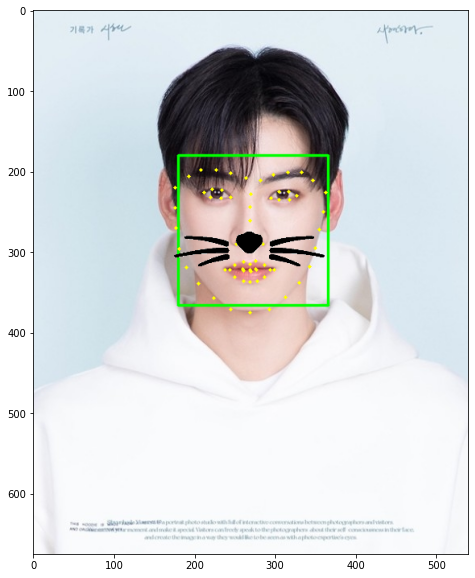

In [222]:
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(face_img_show, cv2.COLOR_BGR2RGB))
plt.show()

> 아주 적용이 잘됐다. 구웃